# Chapter 2: 

# Tinh chỉnh tham số cho mô hình 

Chương 1 chỉ ra rằng khi K = 1 thì mô hình KNN là chưa đủ tốt để chúng ta có thể sử dụng. Tìm kiếm tham số tối ưu sao cho khả năng phân loại - dự báo của mô hình cao nhất có thể được là mấu cơ bản của việc xây dựng và huấn luyện một mô hình học máy. 

Trong chương này chúng ta sẽ tìm hiểu việc thực hiện tinh chỉnh tham số nhằm tìm kiếm tham số tối ưu cho mô hình. Để minh họa KNN sẽ được lựa chọn vì mô hình này đơn giản nhất và chỉ có một tham số là số láng giềng gần nhất. Dữ liệu sử dụng vẫn là bộ *UniversalBank.csv* đã được sử dụng trong chương 1. 

# 2.1 Tinh chỉnh theo phương pháp Manual Search

Tinh chỉnh tham số cho mô hinh theo phương pháp này được tiến hành như sau. Trước hết liệt kê ra một số giá trị của tham số (hoặc một sự kết hợp nào đó của các tham số). Ứng với mỗi giá trị của tham số chúng ta huấn luyện mô hình trên cùng bộ dữ liệu train và kiểm tra ngược lại chất lượng của mô hình trên cùng bộ dữ liệu test để đánh giá xem với giá trị nào của tham số thì khả năng dự báo của mô hình là tốt nhất. 

Để minh họa chúng ta hãy xét mô hình KNN. Đây là mô hình chỉ có một tham số là số láng giềng gần nhất k. Trước hết là đọc dữ liệu và thực hiện chuẩn bị dữ liệu: 

In [1]:
# Đọc dữ liệu: 
import pandas as pd
df_bank = pd.read_csv("C:/Users/Zbook/Desktop/DataMining/dmba/UniversalBank.csv")

In [2]:
#============================
#   Chuẩn bị dữ liệu 
#============================

# Bỏ biến không cần thiết: 
my_df_binary = df_bank.drop(["ZIP Code", "ID"], axis=1) 

# Tách ra features và target: 
Y = my_df_binary["CreditCard"]
X = my_df_binary.drop("CreditCard", 1)

# Phân chia dữ liệu theo tỉ lệ 60 - 40: 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state = 29, stratify = Y)

Số K láng giềng gần nhất sẽ là một số nguyên nhưng **không phải là số chẵn**. Trước hết chúng ta xem xét mô hình KNN với hai giá trị lẻ của K là 1 và 3 như sau: 

Text(0.5,1,'Figure 1: Mô hình KNN khi K = 1')

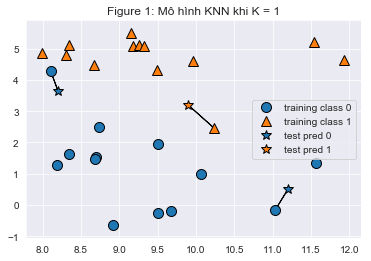

In [3]:
# Import một số thư việc cần thiết cho hình ảnh hóa dữ liệu: 
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

import mglearn as mglearn
mglearn.plots.plot_knn_classification(n_neighbors=1)
plt.title("Figure 1: Mô hình KNN khi K = 1")

Còn với k = 3: 

Text(0.5,1,'Figure 2: Mô hình KNN khi K = 3')

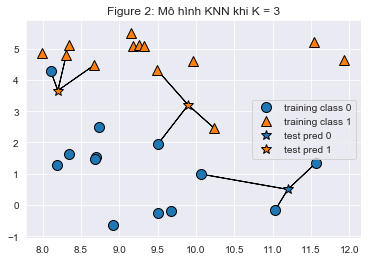

In [4]:
mglearn.plots.plot_knn_classification(n_neighbors=3)
plt.title("Figure 2: Mô hình KNN khi K = 3")

Trong không gian hai chiều, giả sử chúng ta có ba quan sát là những điểm hình sao. Nếu K = 1 thì chúng ta chỉ cần tìm ra duy nhất một quan sát nào mà gần nhất với ba quan sát trên. Vì rằng quan sát gần nhất với hình sao thứ nhất là màu xanh nên mô hình KNN sẽ dự báo quan sát đó là màu xanh. Lập luận tương tự thì KNN sẽ dự báo hai quan sát còn lại lần lượt là vàng và xanh (Figure 1). 

Tuy nhiên nếu K = 3 thì với mỗi một quan sát thì KNN sẽ tìm kiếm 3 quan sát gần nhất với ba điểm hình sao. Trong 3 quan sát gần nhất với điểm hình sao thứ nhất thì có hai quan sát là màu vàng và chỉ có một quan sát là xanh. Trong tình huống này KNN sẽ dự báo điểm hình sao thứ nhất này là màu vàng - chính là màu chiếm đa số trong số 3 láng giềng gần nhất của nó. Tương tự thì điểm hình sao thứ 2 cũng là màu vàng. Với hình sao thứ ba thì điểm hình sao này KNN sẽ dự báo có màu xanh (Figure 2). 

Nếu K = 4 thì rất có thể xẩy ra tình huống sau: 4 láng giềng gần nhất của một quan sát mà KNN cần dự đoán màu thì sẽ có 2 hàng xóm màu vàng, 2 hàng xóm màu đỏ. Trong tình huống không tồn tại màu chiêm ưu thế, KNN sẽ thất bại trong việc dự báo màu cho quan sát mà chúng ta quan tâm. 

Do vậy khi huấn luyện và tinh chỉnh mô hình KNN thì số láng giềng K không nên là số chẵn. Để thực hiện tìm kiếm K tối ưu trước hết chúng ta viết một hàm với đầu vào là K được chọn và kết quả nhận được sẽ là Accuracy. Cụ thể hơn, hàm này sẽ huấn luyện mô hình KNN trên train data ứng với mỗi một K được chọn và sử dụng test data để tính toán Accuracy. Hàm này chúng ta đặt tên là **get_accuracy_k()**. 

In [5]:
# Load các thư viện cần thiết: 
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Viết hàm get_accuracy_k: 

def get_accuracy_k(k_selected):
    
    # Huấn luyện KNN model với k được chọn: 
    knn_k = KNeighborsClassifier(n_neighbors = k_selected)
    knn_k.fit(X_train, y_train)
    
    # Sử dụng KNN cho dự báo và tính Accuracy: 
    y_pred = knn_k.predict(X_test)
    acc = np.mean(y_pred == y_test)
    return(acc)

Với K = 1 thì chúng ta có kết quả sẽ là 0.576 như đã biết ở chương 1: 

In [6]:
get_accuracy_k(k_selected=1)

0.576

In [7]:
# Accurcy khi k = 3: 

In [8]:
get_accuracy_k(k_selected=3)

0.6095

Để khảo sát chất lượng phân lọai của mô hình KNN chúng ta có thể khảo sát các giá trị lẻ của K từ 1 đến 31 rồi tính toán Accuracy tương ứng như sau: 

In [9]:
# Thiết lập một dải giá trị của K:   
k = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

# Tạo ra array trống lưu dữ liệu: 
testing_accuracy = []

# Viết vòng lặp for loop tính toán Accuracy tương ứng với một giá trị của K: 
for i in k:  
    acc = get_accuracy_k(k_selected = i)   
    testing_accuracy.append(acc)

In [10]:
# Xem 3 kết quả đầu: 
testing_accuracy[0:3] 

[0.576, 0.6095, 0.6365]

Chất lượng phân loại của mô hình KNN tương ứng với các giá trị  khác nhau của K: 

Text(0.5,1,'Figure 3: Accuracy vs K khi random_state = 29')

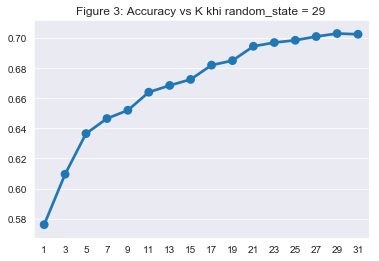

In [11]:
# Minh họa Accuracy khi K thay đổi: 
df_results = {"K": k, "Accuracy": testing_accuracy}
sns.pointplot(x="K", y="Accuracy", data = df_results)
plt.title("Figure 3: Accuracy vs K khi random_state = 29")

Figure 3 lôi kéo chúng ta đến kết luận rằng: k = 29 là giá trị tối ưu vì đó là giá trị của tham số mà Accuracy cao nhất. Liệu kết luận này có đúng? 

Câu trả lời là chưa chắc đúng. Vì rằng những gì chúng ta thấy ở trên mới chỉ dựa trên **một mẫu** số liệu mà thôi. Mẫu số liệu này tương ứng với lựa chọn random_state = 29. Nếu chọn, ví dụ, random_state = 88 thì kết quả lại cho thấy khi K = 27 chứ không phải 29 thì Accuracy của mô hình sẽ là cao nhất: 

Text(0.5,1,'Figure 4: Accuracy vs K khi random_state = 88')

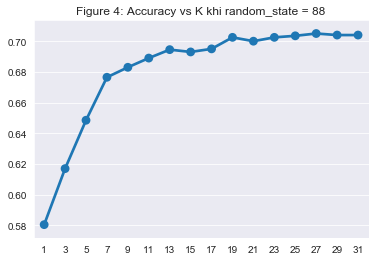

In [12]:
# Thử nghiệm lại với bộ dữ liệu train và test data khác: 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state = 88, stratify = Y)

testing_accuracy = []

# Viết vòng lặp for loop tính toán Accuracy tương ứng với một giá trị của K: 
for i in k:  
    acc = get_accuracy_k(k_selected = i)   
    testing_accuracy.append(acc)
     
df_results = {"K": k, "Accuracy": testing_accuracy}
sns.pointplot(x="K", y="Accuracy", data = df_results)
plt.title("Figure 4: Accuracy vs K khi random_state = 88")    

Vậy thì tham số tối ưu là 27 hay 29 hay thậm chí là một giá trị nào khác?. Để trả lời câu hỏi này chúng ta cần tiếp cận theo hướng như sau. Chuẩn bị sẵn, ví dụ, 5 bộ dữ liệu train và test tương ứng. Khi K = 1 chạy 5 mô hình KNN trên 5 bộ dữ liệu train và tính Accuracy tương ứng với 5 bộ test data. Tính trung bình cho Accuracy. Lặp lại quá trình này cho đến giá trị cuối cùng là 29. Giá trị nào của K mà tạo ra Accuracy trung bình cao nhất thì giá trị đó gần như là tham số tối ưu của mô hình KNN. Rất may mắn là thư viện Scikit-Learn có những hàm cho phép chúng ta thực hiện chiến lược tinh chỉnh tham số này. 

# 2.2 Tinh chỉnh tham số bằng K Fold Cross-Validation 

Đây là một cách tiếp cận phổ biến để tinh chỉnh tham số của các mô hình học máy. Để minh họa chúng ta xét 5 Fold Cross-Validation như minh họa dưới đây: 

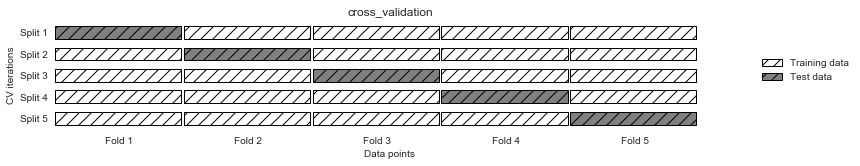

In [13]:
# Minh họa cho 5 Fold Cross-Validation: 
mglearn.plots.plot_cross_validation()

Ở đây bộ dữ liệu ban đầu sẽ được chia thành 5 phần xấp xỉ bằng nhau (mỗi phần gọi là một Fold). Như vậy theo cách chọn mẫu kiểu này chúng ta có 5 phần dữ liệu. Bốn trong số năm phần dữ liệu này sẽ được sử dụng để xây dựng mô hình và phần dữ liệu còn lại sẽ được sử dụng để kiểm tra ngược lại chất lượng của mô hình. Theo phương pháp 5 Fold Cross-Validation thì chúng ta sẽ có 5 giá trị tương ứng của, ví dụ,  Accuracy nếu chọn tiêu chí này để đánh giá mô hình. Dưới đây là Python codes để thực hiện 5 Fold Cross-Validation bằng hàm **cross_val_score()** của thư viện Scikit-Learn: 

In [14]:
# Thực hiện 5 Fold Cross-Validation cho KNN với K = 1: 
knn1 = KNeighborsClassifier(n_neighbors=1)
from sklearn.model_selection import cross_val_score
scores_from_cross = cross_val_score(knn1, X, Y, cv = 5)

In [15]:
# Xem 5 giá trị của Accuracy tương ứng: 
scores_from_cross

array([0.578, 0.582, 0.596, 0.562, 0.59 ])

In [16]:
# Có thể tính trung bình Accuracy của KNN khi K = 1 với 5 lần thử nghiệm: 
np.mean(scores_from_cross)

0.5815999999999999

Để hỗ trợ quá trình tinh chỉnh tham số cho KNN chúng ta viết hàm trả về trung bình Accuracy tương ứng với một giá trị được chọn của K khi sử dụng 5 Fold Cross-Validation: 

In [17]:
def get_average_acc(k_selected): 
    knn = KNeighborsClassifier(n_neighbors=k_selected)
    acc_5Fold = cross_val_score(knn, X, Y, cv = 5)
    avg_acc = np.mean(acc_5Fold)
    return(avg_acc)

Kế tiếp viết vòng lặp for loop tính toán các trung bình Accuracy này cho một dải các giá trị của K: 

In [18]:
# Tạo ra array trống lưu dữ liệu: 
avg_accuracy = []

# Tính toán trung bình Accuracy tương ứng với một giá trị của K: 
for i in k:  
    acc_mean = get_average_acc(k_selected = i)   
    avg_accuracy.append(acc_mean)

Sự biến đổi của trung bình Accuracy theo K chỉ ra rằng K = 31 chính là giá trị tham số tối ưu chứ không phải là 27 hay 29: 

Text(0.5,1,'Figure 5: Average Accuracy dựa trên 5 Fold Cross-Validation')

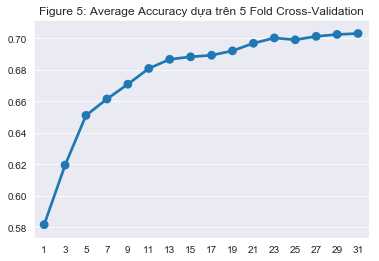

In [19]:
df_results_5Fold = {"K": k, "Avg_Acc": avg_accuracy}
sns.pointplot(x="K", y="Avg_Acc", data = df_results_5Fold)
plt.title("Figure 5: Average Accuracy dựa trên 5 Fold Cross-Validation")  

Chúng ta có thể chỉ ra giá trị lớn nhất này là 70.3% và lưu ý rằng đây là Accuracy trung bình từ thử nghiệm 5 mẫu: 

In [20]:
np.max(avg_accuracy)

0.703

Với kết quả này chúng ta có thể huấn luyện lại KNN với K = 31 đồng thời đánh giá mức độ chính xác khi phân loại trên test data: 

In [21]:
knn31 = KNeighborsClassifier(n_neighbors=31)
knn31.fit(X_train, y_train).score(X_test, y_test)

0.704

# 2.3 Tóm tắt chương

Chương này trình bày chi tiết khía cạnh thực hành cho quá trình tinh chỉnh tham số cho mô hình học máy. Với mục đích minh họa thì KNN được lựa chọn vì mức độ đơn giản và tính toán nhanh chóng của nó nhưng ý tưởng và cách tiếp cận cho việc tinh chỉnh tham số như đã biết có thể được áp dụng cho mọi mô hình học máy khác. 

Một số cách tiếp cận khác tinh vi hơn cho tinh chỉnh tham số sẽ được trình bày trong những chương sau. 

# Tài Liệu Tham Khảo

1. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer.

2. Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. New York: Springer.

3. Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: a guide for data scientists. "O'Reilly Media, Inc.".

4. Géron, A. (2019). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

5. Shmueli, G., Bruce, P. C., Yahav, I., Patel, N. R., & Lichtendahl Jr, K. C. (2017). Data mining for business analytics: concepts, techniques, and applications in R. John Wiley & Sons. 

